In [1]:
%%capture
!pip install deepchem transformers peft

In [12]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType, AdaLoraConfig
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [5]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [6]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        """
        Custom PyTorch Dataset for the ClinTox dataset.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active data split based on input parameter
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        """
        Filters out invalid SMILES strings using RDKit validation.
        """
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [7]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the validation or test set.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary predictions for accuracy
    bin_preds = (all_preds > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, bin_preds)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    percentage_trained = round(100*trainable_params/all_params, 2)
    print(f"Trainable: {trainable_params} | All: {all_params} | % Trained: {percentage_trained}")
    return trainable_params, all_params, percentage_trained

In [9]:
def train_and_profile(model, tokenizer, optimization_name, lr=LEARNING_RATE):
    """
    Train and evaluate a model with comprehensive logging to Weights & Biases
    """

    print(f"\n--- {optimization_name} - Trainable Parameters ---")
    trainable_params, all_params, percentage_trained = print_trainable_parameters(model)

    # Initialize a new wandb run for this experiment
    run = wandb.init(
        project="chemberta",
        entity="hpml-proj-deepchem",
        name=f"{optimization_name}_lr{lr}",
        config={
            "model_name": MODEL_NAME,
            "optimization": optimization_name,
            "learning_rate": lr,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "max_length": MAX_LENGTH,
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT,
        }
    )

    wandb.log({
        "trainable_parameters": trainable_params,
        "total_parameters": all_params,
        "parameter_efficiency": percentage_trained
    })

    # Create datasets for each split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    val_dataset = ClinToxDataset("clintox", tokenizer, split="valid", max_length=MAX_LENGTH)
    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # training loop
    train_losses, val_losses, val_accuracies = [], [], []

    print(f"\n--- {optimization_name} ---")

    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        # batch processing
        for batch in progress_bar:
            # move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)

            # BACKWARD PASS
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # metric calculations
        epoch_time = time.time() - epoch_start_time

        avg_train_loss = total_train_loss / len(train_dataloader)
        val_loss, val_acc = evaluate_model(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # wandb logging
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch_time": epoch_time,
            "model_type": optimization_name
        })


        print(f"Epoch {epoch+1} | Training Time: {epoch_time:.2f} s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    end_time = time.time()

    test_loss, test_acc = evaluate_model(model, test_dataloader, device)
    training_time = round(end_time - start_time, 2)
    print(f"\n--- {optimization_name} ---")
    print(f"Training time: {training_time} seconds")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "training_time": training_time,
        "trainable_parameters": trainable_params,
        "total_parameters": all_params,
        "parameter_efficiency": percentage_trained,
        "model_type": optimization_name
    })

    wandb.log({
        f"{optimization_name}_train_loss_curve": wandb.plot.line_series(
            xs=list(range(1, EPOCHS+1)),
            ys=[train_losses],
            keys=[f"{optimization_name}_train_loss"],
            title=f"{optimization_name} Training Loss",
            xname="Epoch"
        ),
        f"{optimization_name}_val_loss_curve": wandb.plot.line_series(
            xs=list(range(1, EPOCHS+1)),
            ys=[val_losses],
            keys=[f"{optimization_name}_val_loss"],
            title=f"{optimization_name} Validation Loss",
            xname="Epoch"
        )
    })

    wandb.finish()

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "training_time": training_time,
        "test_accuracy": test_acc,
        "trainable_parameters": trainable_params}

In [10]:
def hyperparameter_tuning(model_type="LoRA", learning_rates=[1e-5, 2e-5, 3e-5, 5e-5, 1e-4, 3e-4]):
    """
    Run hyperparameter tuning  with wandb tracking
    """

    # Initialize the main sweep run
    parent_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Sweep", job_type="sweep")

    results = {
        "learning_rate": [],
        "test_accuracy": [],
        "training_time": [],
    }

    # Run experiment for each learning rate
    for lr in learning_rates:
        print(f"\n--- {model_type} with learning_rate={lr} ---")

        # new model for each run
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        model = None

        if model_type.lower() == "lora":
            model = setup_lora_model(MODEL_NAME)
        elif model_type.lower() == "adalora":
            model = setup_adalora_model(MODEL_NAME)

        with wandb.init(
            project="chemberta",
            entity="hpml-proj-deepchem",
            name=f"{model_type}_lr_{lr}",
            group=f"{model_type}_Sweep",
            job_type="run",
            config={"learning_rate": lr},
            reinit=True  # Allows multiple init calls
        ):

            metrics = train_and_profile(model, tokenizer, f"{model_type}_lr_{lr}", lr=lr)

            results["learning_rate"].append(lr)
            results["test_accuracy"].append(metrics["test_accuracy"])
            results["training_time"].append(metrics["training_time"])

        # Clean up memory
        del model, tokenizer
        torch.cuda.empty_cache()
    wandb.finish()
    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Create and log summary visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(results_df["learning_rate"], results_df["test_accuracy"], 'bo-')
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'{model_type} Performance vs Learning Rate')
    ax.grid(True)

    # Add text annotations for each point
    for i, lr in enumerate(results_df["learning_rate"]):
        ax.annotate(
            f"Time: {results_df['training_time'][i]:.1f}s\nAcc: {results_df['test_accuracy'][i]:.4f}",
            (lr, results_df["test_accuracy"][i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    second_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Graph")
    wandb.log({f"{model_type}_lr_tuning_curve": wandb.Image(fig)})
    wandb.finish()

    third_run = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"{model_type}_Hyperparameter_Graph")
    wandb.log({f"{model_type}_lr_tuning_table": wandb.Table(dataframe=results_df)})
    wandb.finish()

    return results_df


## Base ChemBeRTa Model Without Any Additional Fine-Tuning

In [13]:
baseline = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline.to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


_, test_acc = evaluate_model(baseline, test_dataloader, device)

print(f"Baseline (Not Fine-Tuned) Test Accuracy: {test_acc:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 5/5 [00:00<00:00, 22.85it/s]

Baseline (Not Fine-Tuned) Test Accuracy: 0.1486


## Base ChemBeRTa Model with Full Parameter Fine-Tuning


In [14]:
def setup_baseline_model(model_name):
    """
    Set up a baseline model
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )
    return model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_baseline = setup_baseline_model(MODEL_NAME)

baseline_metrics = train_and_profile(model_baseline, tokenizer, "Model_Baseline_Finetuned")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Model_Baseline_Finetuned - Trainable Parameters ---
Trainable: 44105474 | All: 44105474 | % Trained: 100.0



--- Model_Baseline_Finetuned ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Epoch 1 | Training Time: 5.46 s | Train Loss: 0.2483 | Val Loss: 0.0837 | Val Accuracy: 0.9865


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Epoch 2 | Training Time: 5.20 s | Train Loss: 0.0801 | Val Loss: 0.1064 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


Epoch 3 | Training Time: 5.21 s | Train Loss: 0.0545 | Val Loss: 0.1912 | Val Accuracy: 0.9189


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.38it/s]


Epoch 4 | Training Time: 5.25 s | Train Loss: 0.0463 | Val Loss: 0.0727 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s]


Epoch 5 | Training Time: 5.28 s | Train Loss: 0.0352 | Val Loss: 0.1611 | Val Accuracy: 0.9189


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]



--- Model_Baseline_Finetuned ---
Training time: 27.58 seconds
Test Loss: 0.0678 | Test Accuracy: 0.9730


epoch,▁▃▅▆█
epoch_time,█▁▁▂▃
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▂▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,█▅▁▇▁
val_loss,▂▃█▁▆


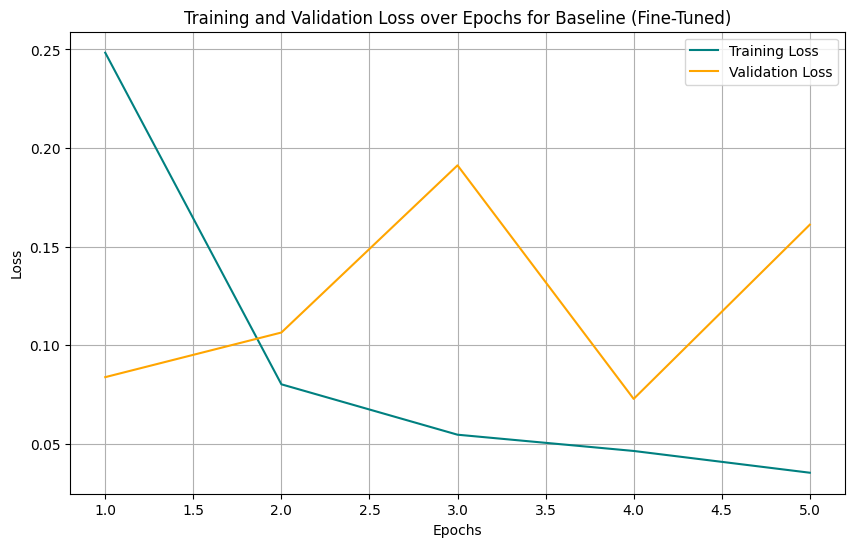

epoch,▁▃▅▆█
train_loss,█▂▂▁▁
val_loss,▂▃█▁▆
epoch,5
train_loss,0.03523
val_loss,0.16107


<Figure size 640x480 with 0 Axes>

In [24]:
# Graph training and validation losses from baseline_metrics
train_losses = baseline_metrics['train_losses']
val_losses = baseline_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="Baseline_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Baseline (Fine-Tuned)')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"baseline_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

## ChemBeRTa With LoRA Fine-Tuning

In [16]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model


--- LoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



--- LoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.28it/s]


Epoch 1 | Training Time: 3.81 s | Train Loss: 0.5133 | Val Loss: 0.3332 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


Epoch 2 | Training Time: 3.83 s | Train Loss: 0.3204 | Val Loss: 0.2277 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.06it/s]


Epoch 3 | Training Time: 3.87 s | Train Loss: 0.2585 | Val Loss: 0.1938 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Epoch 4 | Training Time: 3.87 s | Train Loss: 0.2354 | Val Loss: 0.1784 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.62it/s]


Epoch 5 | Training Time: 3.87 s | Train Loss: 0.2145 | Val Loss: 0.1678 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.91it/s]



--- LoRA_lr_1e-05 ---
Training time: 20.53 seconds
Test Loss: 0.1691 | Test Accuracy: 0.9324


epoch,▁▃▅▆█
epoch_time,▁▄█▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▂▁▁



--- LoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


Epoch 1 | Training Time: 3.89 s | Train Loss: 0.4320 | Val Loss: 0.2242 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.75it/s]


Epoch 2 | Training Time: 3.92 s | Train Loss: 0.2496 | Val Loss: 0.1766 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.72it/s]


Epoch 3 | Training Time: 3.94 s | Train Loss: 0.2136 | Val Loss: 0.1607 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.57it/s]


Epoch 4 | Training Time: 3.94 s | Train Loss: 0.1856 | Val Loss: 0.1452 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]


Epoch 5 | Training Time: 3.99 s | Train Loss: 0.1617 | Val Loss: 0.1302 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]



--- LoRA_lr_2e-05 ---
Training time: 20.97 seconds
Test Loss: 0.1220 | Test Accuracy: 0.9527


epoch,▁▃▅▆█
epoch_time,▁▃▄▄█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁█
val_loss,█▄▃▂▁



--- LoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.83it/s]


Epoch 1 | Training Time: 3.91 s | Train Loss: 0.3504 | Val Loss: 0.1815 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


Epoch 2 | Training Time: 3.93 s | Train Loss: 0.2185 | Val Loss: 0.1592 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 3 | Training Time: 3.93 s | Train Loss: 0.1821 | Val Loss: 0.1400 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Epoch 4 | Training Time: 3.94 s | Train Loss: 0.1465 | Val Loss: 0.1186 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Epoch 5 | Training Time: 3.95 s | Train Loss: 0.1219 | Val Loss: 0.1011 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]



--- LoRA_lr_3e-05 ---
Training time: 20.96 seconds
Test Loss: 0.0888 | Test Accuracy: 0.9730


epoch,▁▃▅▆█
epoch_time,▁▄▅▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▃▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁██
val_loss,█▆▄▃▁



--- LoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.72it/s]


Epoch 1 | Training Time: 3.89 s | Train Loss: 0.3059 | Val Loss: 0.1669 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


Epoch 2 | Training Time: 3.90 s | Train Loss: 0.1850 | Val Loss: 0.1374 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Epoch 3 | Training Time: 3.92 s | Train Loss: 0.1361 | Val Loss: 0.1083 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


Epoch 4 | Training Time: 3.95 s | Train Loss: 0.1023 | Val Loss: 0.0927 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.36it/s]


Epoch 5 | Training Time: 3.96 s | Train Loss: 0.0813 | Val Loss: 0.0914 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.88it/s]



--- LoRA_lr_5e-05 ---
Training time: 20.91 seconds
Test Loss: 0.0800 | Test Accuracy: 0.9662


epoch,▁▃▅▆█
epoch_time,▁▂▄██
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▃▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▆██
val_loss,█▅▃▁▁



--- LoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


Epoch 1 | Training Time: 3.90 s | Train Loss: 0.2534 | Val Loss: 0.1368 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]


Epoch 2 | Training Time: 3.91 s | Train Loss: 0.1323 | Val Loss: 0.0966 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Epoch 3 | Training Time: 3.94 s | Train Loss: 0.0845 | Val Loss: 0.0841 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s]


Epoch 4 | Training Time: 3.96 s | Train Loss: 0.0635 | Val Loss: 0.0891 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Epoch 5 | Training Time: 3.97 s | Train Loss: 0.0550 | Val Loss: 0.0945 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.72it/s]



--- LoRA_lr_0.0001 ---
Training time: 21.01 seconds
Test Loss: 0.0670 | Test Accuracy: 0.9730


epoch,▁▃▅▆█
epoch_time,▁▂▅▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▅██▃
val_loss,█▃▁▂▂



--- LoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


Epoch 1 | Training Time: 3.90 s | Train Loss: 0.1846 | Val Loss: 0.0949 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 2 | Training Time: 3.93 s | Train Loss: 0.0744 | Val Loss: 0.0826 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s]


Epoch 3 | Training Time: 3.92 s | Train Loss: 0.0572 | Val Loss: 0.1395 | Val Accuracy: 0.9324


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 4 | Training Time: 3.95 s | Train Loss: 0.0407 | Val Loss: 0.0972 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 5 | Training Time: 3.96 s | Train Loss: 0.0343 | Val Loss: 0.0780 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]



--- LoRA_lr_0.0003 ---
Training time: 20.97 seconds
Test Loss: 0.0628 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▄▃▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,█▇▁▅▇
val_loss,▃▂█▃▁


,learning_rate,test_accuracy,training_time
0,0.00001,0.932432,20.53
1,0.00002,0.952703,20.97
2,0.00003,0.972973,20.96
3,0.00005,0.966216,20.91
4,0.00010,0.972973,21.01
5,0.00030,0.979730,20.97


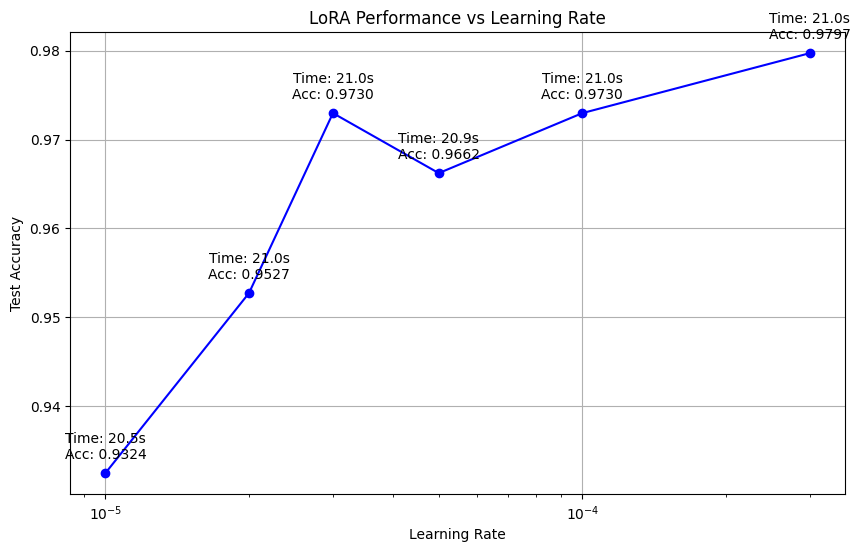

In [17]:
hyperparameter_tuning("LoRA")

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_lora = setup_lora_model(MODEL_NAME)
BEST_LR_LORA = 3e-4
lora_metrics = train_and_profile(model_lora, tokenizer, "LoRA", lr=BEST_LR_LORA)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65



--- LoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.57it/s]


Epoch 1 | Training Time: 3.93 s | Train Loss: 0.1988 | Val Loss: 0.1044 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.67it/s]


Epoch 2 | Training Time: 3.93 s | Train Loss: 0.0882 | Val Loss: 0.1119 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.36it/s]


Epoch 3 | Training Time: 3.97 s | Train Loss: 0.0577 | Val Loss: 0.0764 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Epoch 4 | Training Time: 3.97 s | Train Loss: 0.0524 | Val Loss: 0.0836 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.67it/s]


Epoch 5 | Training Time: 3.98 s | Train Loss: 0.0453 | Val Loss: 0.0836 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.64it/s]



--- LoRA ---
Training time: 21.08 seconds
Test Loss: 0.0526 | Test Accuracy: 0.9865


epoch,▁▃▅▆█
epoch_time,▁▂▆▇█
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▅▁█▇▇
val_loss,▇█▁▂▂


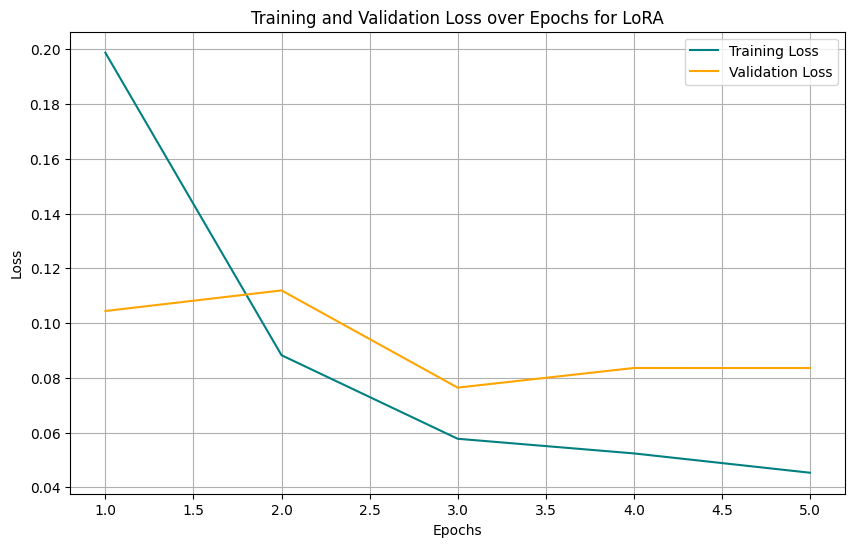

epoch,▁▃▅▆█
train_loss,█▃▂▁▁
val_loss,▇█▁▂▂
epoch,5
train_loss,0.04531
val_loss,0.08356


<Figure size 640x480 with 0 Axes>

In [19]:
# Graph training and validation losses from lora_metrics
train_losses = lora_metrics['train_losses']
val_losses = lora_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="LoRA_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for LoRA')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"lora_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

## ChemBeRTa With AdaLoRA Fine-Tuning

In [20]:
def setup_adalora_model(model_name):
    """
    Set up a model with AdaLoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    ADA_TOTALSTEP = EPOCHS * len(train_dataloader)

    peft_config = AdaLoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        total_step = ADA_TOTALSTEP
    )

    model = get_peft_model(model, peft_config)
    return model


--- AdaLoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.76it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.5221 | Val Loss: 0.3295 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s]


Epoch 2 | Training Time: 5.91 s | Train Loss: 0.3331 | Val Loss: 0.2278 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 3 | Training Time: 5.92 s | Train Loss: 0.2713 | Val Loss: 0.1954 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Epoch 4 | Training Time: 5.95 s | Train Loss: 0.2438 | Val Loss: 0.1805 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Epoch 5 | Training Time: 5.91 s | Train Loss: 0.2289 | Val Loss: 0.1712 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]



--- AdaLoRA_lr_1e-05 ---
Training time: 31.21 seconds
Test Loss: 0.1805 | Test Accuracy: 0.9324


epoch,▁▃▅▆█
epoch_time,▁▃▅█▄
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▂▁▁



--- AdaLoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Epoch 1 | Training Time: 5.85 s | Train Loss: 0.4242 | Val Loss: 0.2173 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Epoch 2 | Training Time: 5.90 s | Train Loss: 0.2489 | Val Loss: 0.1766 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Epoch 3 | Training Time: 5.92 s | Train Loss: 0.2195 | Val Loss: 0.1640 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


Epoch 4 | Training Time: 5.94 s | Train Loss: 0.1969 | Val Loss: 0.1550 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


Epoch 5 | Training Time: 5.95 s | Train Loss: 0.1820 | Val Loss: 0.1482 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]



--- AdaLoRA_lr_2e-05 ---
Training time: 31.24 seconds
Test Loss: 0.1395 | Test Accuracy: 0.9527


epoch,▁▃▅▆█
epoch_time,▁▅▆██
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▃▂▁



--- AdaLoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.3544 | Val Loss: 0.1835 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Epoch 2 | Training Time: 5.90 s | Train Loss: 0.2238 | Val Loss: 0.1631 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Epoch 3 | Training Time: 5.92 s | Train Loss: 0.1976 | Val Loss: 0.1517 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


Epoch 4 | Training Time: 5.93 s | Train Loss: 0.1683 | Val Loss: 0.1422 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


Epoch 5 | Training Time: 5.93 s | Train Loss: 0.1557 | Val Loss: 0.1348 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]



--- AdaLoRA_lr_3e-05 ---
Training time: 31.2 seconds
Test Loss: 0.1218 | Test Accuracy: 0.9459


epoch,▁▃▅▆█
epoch_time,▁▄▆██
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁



--- AdaLoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.3337 | Val Loss: 0.1679 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Epoch 2 | Training Time: 5.92 s | Train Loss: 0.1947 | Val Loss: 0.1479 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


Epoch 3 | Training Time: 5.91 s | Train Loss: 0.1632 | Val Loss: 0.1359 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Epoch 4 | Training Time: 5.97 s | Train Loss: 0.1444 | Val Loss: 0.1270 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Epoch 5 | Training Time: 5.94 s | Train Loss: 0.1328 | Val Loss: 0.1199 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]



--- AdaLoRA_lr_5e-05 ---
Training time: 31.26 seconds
Test Loss: 0.1045 | Test Accuracy: 0.9527


epoch,▁▃▅▆█
epoch_time,▁▄▃█▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▁▁█
val_loss,█▅▃▂▁



--- AdaLoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]


Epoch 1 | Training Time: 5.87 s | Train Loss: 0.2602 | Val Loss: 0.1475 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Epoch 2 | Training Time: 5.92 s | Train Loss: 0.1533 | Val Loss: 0.1282 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 3 | Training Time: 5.93 s | Train Loss: 0.1319 | Val Loss: 0.1177 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]


Epoch 4 | Training Time: 5.94 s | Train Loss: 0.1193 | Val Loss: 0.1089 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Epoch 5 | Training Time: 5.93 s | Train Loss: 0.0942 | Val Loss: 0.0955 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]



--- AdaLoRA_lr_0.0001 ---
Training time: 31.23 seconds
Test Loss: 0.0753 | Test Accuracy: 0.9595


epoch,▁▃▅▆█
epoch_time,▁▆██▇
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▃▃▂▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▁▅██
val_loss,█▅▄▃▁



--- AdaLoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.2289 | Val Loss: 0.1275 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Epoch 2 | Training Time: 5.92 s | Train Loss: 0.1212 | Val Loss: 0.1046 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


Epoch 3 | Training Time: 5.92 s | Train Loss: 0.0864 | Val Loss: 0.0804 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Epoch 4 | Training Time: 5.96 s | Train Loss: 0.0621 | Val Loss: 0.0822 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Epoch 5 | Training Time: 5.94 s | Train Loss: 0.0518 | Val Loss: 0.0757 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]



--- AdaLoRA_lr_0.0003 ---
Training time: 31.28 seconds
Test Loss: 0.0576 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▅▅█▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▂▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▃███
val_loss,█▅▂▂▁


,learning_rate,test_accuracy,training_time
0,0.00001,0.932432,31.21
1,0.00002,0.952703,31.24
2,0.00003,0.945946,31.20
3,0.00005,0.952703,31.26
4,0.00010,0.959459,31.23
5,0.00030,0.979730,31.28


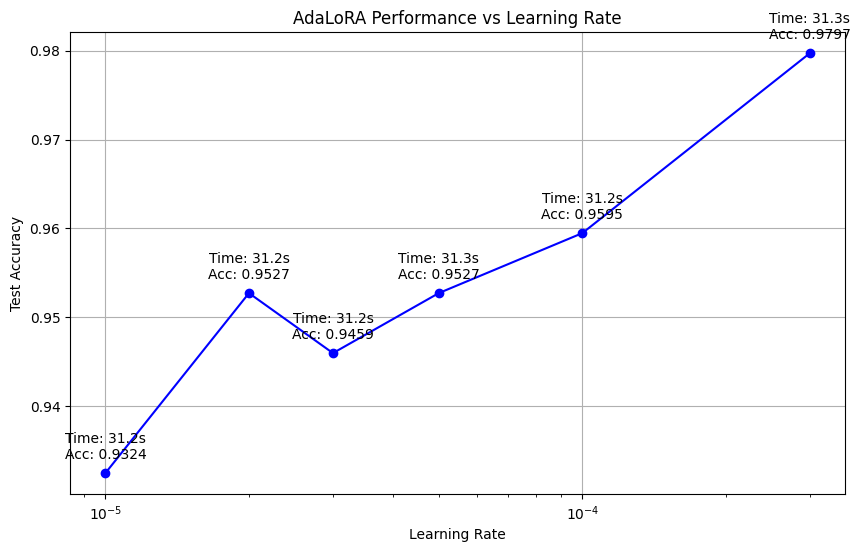

In [21]:
hyperparameter_tuning("AdaLoRA")

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_adalora = setup_adalora_model(MODEL_NAME)
BEST_LR_ADALORA = 3e-4
adalora_metrics = train_and_profile(model_adalora, tokenizer, "AdaLoRA", lr = BEST_LR_LORA)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51



--- AdaLoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Epoch 1 | Training Time: 5.91 s | Train Loss: 0.1926 | Val Loss: 0.1177 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 2 | Training Time: 5.93 s | Train Loss: 0.1107 | Val Loss: 0.1073 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


Epoch 3 | Training Time: 5.97 s | Train Loss: 0.0867 | Val Loss: 0.0752 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch 4 | Training Time: 6.01 s | Train Loss: 0.0563 | Val Loss: 0.0860 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 5 | Training Time: 5.98 s | Train Loss: 0.0463 | Val Loss: 0.0843 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]



--- AdaLoRA ---
Training time: 31.45 seconds
Test Loss: 0.0611 | Test Accuracy: 0.9797


epoch,▁▃▅▆█
epoch_time,▁▂▅█▆
parameter_efficiency,▁▁
test_accuracy,▁
test_loss,▁
total_parameters,▁▁
train_loss,█▄▃▁▁
trainable_parameters,▁▁
training_time,▁
val_accuracy,▁▃█▆▃
val_loss,█▆▁▃▂


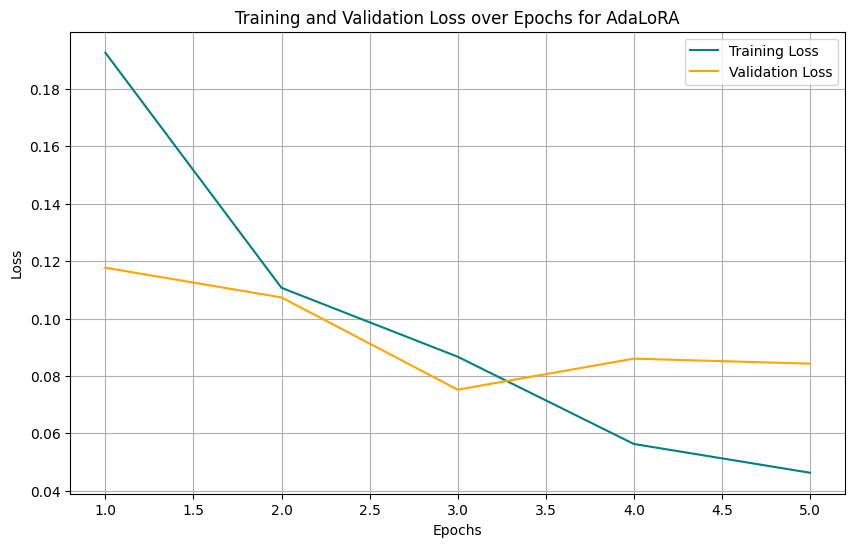

epoch,▁▃▅▆█
train_loss,█▄▃▁▁
val_loss,█▆▁▃▂
epoch,5
train_loss,0.04628
val_loss,0.08428


<Figure size 640x480 with 0 Axes>

In [23]:
# Graph training and validation losses from adalora_metrics
train_losses = adalora_metrics['train_losses']
val_losses = adalora_metrics['val_losses']
epochs = range(1, len(train_losses) + 1)

wandb.init(
    project="chemberta",
    entity="hpml-proj-deepchem",
    name="AdaLoRA_Loss_Curves"
)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='teal')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for AdaLoRA')
plt.legend()
plt.grid(True)
plt.show()

wandb.log({"adalora_train_val_loss": wandb.Image(plt)})

for i in range(len(train_losses)):
    wandb.log({
        "epoch": i+1,
        "train_loss": train_losses[i],
        "val_loss": val_losses[i]
    })

wandb.finish()

In [25]:
def compare_models(baseline_metrics, lora_metrics, adalora_metrics):
    """
    Log a bar chart comparing training time, test accuracy, and parameter count for all models.
    """
    wandb.init(project="chemberta", entity="hpml-proj-deepchem", name="Model_Comparison")
    models = ["Baseline", "LoRA", "AdaLoRA"]
    test_accuracies = [baseline_metrics["test_accuracy"], lora_metrics["test_accuracy"], adalora_metrics["test_accuracy"]]
    training_times = [baseline_metrics["training_time"], lora_metrics["training_time"], adalora_metrics["training_time"]]
    param_counts = [baseline_metrics["trainable_parameters"], lora_metrics["trainable_parameters"], adalora_metrics["trainable_parameters"]]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].bar(models, test_accuracies, color=["blue", "green", "red"])
    axs[0].set_title("Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[1].bar(models, training_times, color=["blue", "green", "red"])
    axs[1].set_title("Training Time (s)")
    axs[1].set_ylabel("Seconds")
    axs[2].bar(models, param_counts, color=["blue", "green", "red"])
    axs[2].set_title("Trainable Parameters")
    axs[2].set_ylabel("Count")
    axs[2].set_yscale("log")
    plt.tight_layout()
    wandb.log({"model_comparison": wandb.Image(fig)})
    wandb.finish()


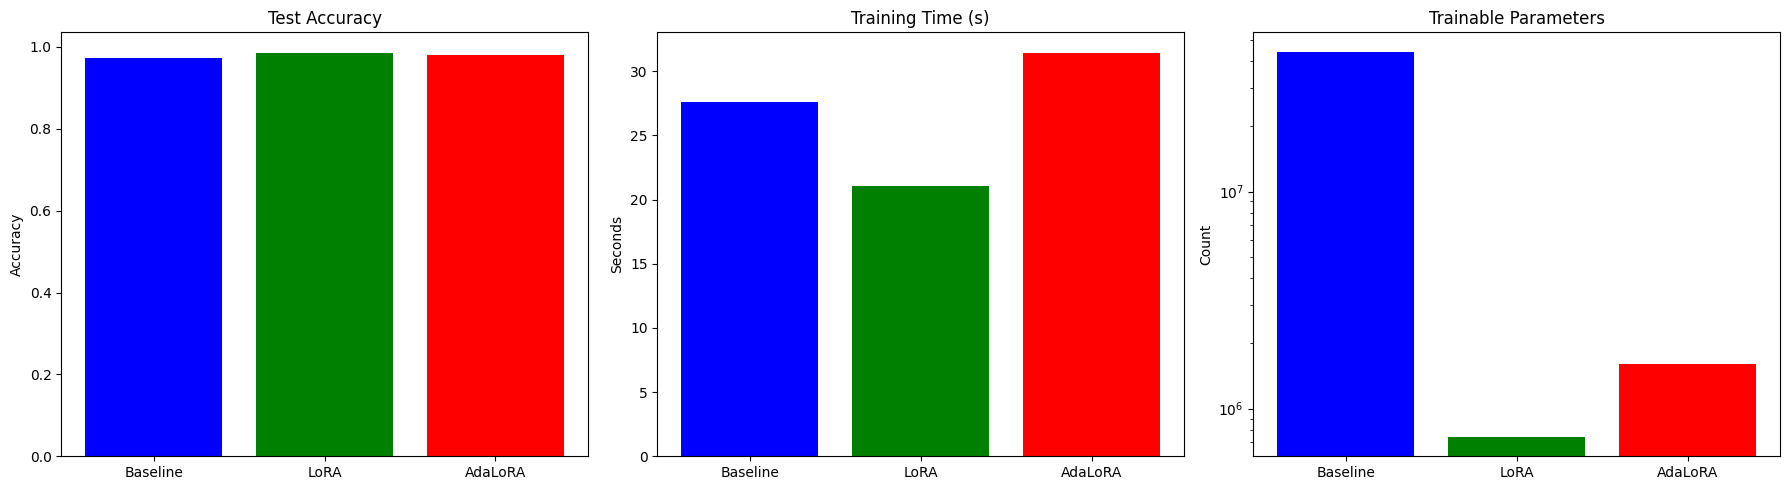

In [26]:
compare_models(baseline_metrics, lora_metrics, adalora_metrics)